## Import Libraries

In [1]:
import ydata_profiling as ydp
import pandas as pd
import numpy as np
import webbrowser as wb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random

In [2]:
df = pd.read_csv("imdb_movies_shows.csv")

## Exploratory Data Analysis (EDA)

In [3]:
print(df.head())
print()
print(df.info())

                                 title   type  release_year age_certification  \
0  Five Came Back: The Reference Films   SHOW          1945             TV-MA   
1                          Taxi Driver  MOVIE          1976                 R   
2      Monty Python and the Holy Grail  MOVIE          1975                PG   
3                        Life of Brian  MOVIE          1979                 R   
4                         The Exorcist  MOVIE          1973                 R   

   runtime                 genres production_countries  seasons    imdb_id  \
0       48      ['documentation']               ['US']      1.0        NaN   
1      113     ['crime', 'drama']               ['US']      NaN  tt0075314   
2       91  ['comedy', 'fantasy']               ['GB']      NaN  tt0071853   
3       94             ['comedy']               ['GB']      NaN  tt0079470   
4      133             ['horror']               ['US']      NaN  tt0070047   

   imdb_score  imdb_votes  
0         NaN   

In [4]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [5]:
summary(df).style.background_gradient(cmap='YlOrBr')

data shape: (5806, 11)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
title,object,1,0.017224,5751,nan,nan,nan,nan,Five Came Back: The Reference Films,Taxi Driver,Monty Python and the Holy Grail
type,object,0,0.000000,2,nan,nan,nan,nan,SHOW,MOVIE,MOVIE
release_year,int64,0,0.000000,67,1945.000000,2022.000000,2016.013434,7.324883,1945,1976,1975
age_certification,object,2610,44.953496,11,nan,nan,nan,nan,TV-MA,R,PG
runtime,int64,0,0.000000,205,0.000000,251.000000,77.643989,39.474160,48,113,91
genres,object,0,0.000000,1626,nan,nan,nan,nan,['documentation'],"['crime', 'drama']","['comedy', 'fantasy']"
production_countries,object,0,0.000000,449,nan,nan,nan,nan,['US'],['US'],['GB']
seasons,float64,3759,64.743369,23,1.000000,42.000000,2.165608,2.636207,1.000000,nan,nan
imdb_id,object,444,7.647261,5362,nan,nan,nan,nan,nan,tt0075314,tt0071853
imdb_score,float64,523,9.007923,81,1.500000,9.600000,6.533447,1.160932,nan,8.300000,8.200000


## EDA with ydataprofiling

In [6]:
ITD214_report = ydp.ProfileReport(df)
ITD214_report.to_file('ITD214_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
wb.open_new_tab('ITD214_report.html')

True

# Additional Visualisations

In [8]:
# Distribution of movie/show runtime|
df['runtime'].plot.hist(bins=15, alpha=0.5)

<Axes: ylabel='Frequency'>

In [9]:
# Distribution of imdb_score
df['imdb_score'].plot.hist(bins=15, alpha=0.5)

<Axes: ylabel='Frequency'>

In [10]:
# Distribution of movies/shows by production countries (top 50)
plt.figure(figsize=(15, 6))  
df['production_countries'].value_counts().head(50).plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.show()

C:\Users\JianWei\AppData\Local\Temp\ipykernel_15204\188375066.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [11]:
# Distribution for release year
df['release_year'].plot.hist(bins=15, alpha=0.5)

<Axes: ylabel='Frequency'>

## Data Cleaning (Part 1)

In [12]:
# Generare Title + Year to verify uniqueness

df['title_year'] = df['title'] + df['release_year'].astype(str)

# Remove duplicated rows

df.drop_duplicates(subset=['title_year'], inplace=True)
df.shape

(5802, 12)

In [13]:
# Remove rows where imdb_votes is NaN (as imdb_votes is the target variable)

df = df.dropna(subset='imdb_votes')

In [14]:
# Remove rows where runtime = 0 (logical exclusion)

df = df[~df[['runtime']].isin([0]).any(axis=1)]

In [15]:
# Reset index for summary function to work

df = df.reset_index()

## Feature Engineering

In [16]:
# Multiple runtime with seasons to capture total time

df['seasons'] = df['seasons'].fillna(1)
df['runtime_combined'] = df['runtime'].astype(float) * df['seasons'].astype(float)

In [17]:
# Preparation for one-hot encoding of 'genres' with validation

# Validation - Datatype before conversion
print("Before conversion:")
print(df['genres'].head())
print("Data type:", df['genres'].dtype)

# Convert string representations of lists into actual lists
df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x))

# Validation - Datatype after conversion
print("\nAfter conversion:")
print(df['genres'].head())
print("Data type of first element:", type(df['genres'][0]))

# Validation - Manual Observation Method
for index, genres in enumerate(df['genres']):
    print(f"Row {index}: {genres} (Type: {type(genres)})")

Before conversion:
0        ['crime', 'drama']
1     ['comedy', 'fantasy']
2                ['comedy']
3                ['horror']
4    ['comedy', 'european']
Name: genres, dtype: object
Data type: object

After conversion:
0        [crime, drama]
1     [comedy, fantasy]
2              [comedy]
3              [horror]
4    [comedy, european]
Name: genres, dtype: object
Data type of first element: <class 'list'>
Row 0: ['crime', 'drama'] (Type: <class 'list'>)
Row 1: ['comedy', 'fantasy'] (Type: <class 'list'>)
Row 2: ['comedy'] (Type: <class 'list'>)
Row 3: ['horror'] (Type: <class 'list'>)
Row 4: ['comedy', 'european'] (Type: <class 'list'>)
Row 5: ['thriller', 'crime', 'action'] (Type: <class 'list'>)
Row 6: ['drama', 'music', 'romance', 'family'] (Type: <class 'list'>)
Row 7: ['romance', 'drama'] (Type: <class 'list'>)
Row 8: ['drama', 'crime', 'action'] (Type: <class 'list'>)
Row 9: ['western', 'action', 'european'] (Type: <class 'list'>)
Row 10: ['war', 'action', 'drama'] (Type: <

Row 1774: ['drama', 'comedy'] (Type: <class 'list'>)
Row 1775: ['action', 'drama', 'history'] (Type: <class 'list'>)
Row 1776: ['comedy', 'drama'] (Type: <class 'list'>)
Row 1777: ['drama', 'thriller', 'crime'] (Type: <class 'list'>)
Row 1778: ['drama', 'european'] (Type: <class 'list'>)
Row 1779: ['drama', 'thriller', 'crime'] (Type: <class 'list'>)
Row 1780: ['drama', 'crime'] (Type: <class 'list'>)
Row 1781: ['action', 'family', 'comedy', 'drama'] (Type: <class 'list'>)
Row 1782: ['drama', 'documentation', 'war', 'thriller'] (Type: <class 'list'>)
Row 1783: ['comedy', 'drama', 'crime'] (Type: <class 'list'>)
Row 1784: ['animation', 'action', 'drama', 'family', 'fantasy'] (Type: <class 'list'>)
Row 1785: ['scifi', 'comedy', 'thriller', 'drama', 'horror'] (Type: <class 'list'>)
Row 1786: ['scifi', 'thriller', 'drama', 'horror', 'fantasy'] (Type: <class 'list'>)
Row 1787: ['thriller', 'drama', 'action', 'crime', 'fantasy', 'scifi'] (Type: <class 'list'>)
Row 1788: ['thriller', 'action'

In [18]:
# One-hot enccoding of 'type' column

In [19]:
df = pd.get_dummies(df, columns=['type'], prefix='type')

In [20]:
# One-hot encoding of 'genres' column
mlb = MultiLabelBinarizer()
transformed = mlb.fit_transform(df['genres'])
genre_labels = mlb.classes_

# Create a temporary DataFrame for the new 'genres' columns
genres_df = pd.DataFrame(transformed, columns=genre_labels)

# Concatenate with original DataFrame
df_2 = pd.concat([df, genres_df], axis=1).drop('genres', axis=1)

# Display the new DataFrame with one-hot encoded 'genres'
print(df_2)

      index                            title  release_year age_certification  \
0         1                      Taxi Driver          1976                 R   
1         2  Monty Python and the Holy Grail          1975                PG   
2         3                    Life of Brian          1979                 R   
3         4                     The Exorcist          1973                 R   
4         5     Monty Python's Flying Circus          1969             TV-14   
...     ...                              ...           ...               ...   
5242   5798                    Time to Dance          2021               NaN   
5243   5800      Momshies! Your Soul is Mine          2021               NaN   
5244   5801                        Fine Wine          2021               NaN   
5245   5803                            Clash          2021               NaN   
5246   5804                   Shadow Parties          2021               NaN   

      runtime production_countries  sea

In [21]:
# Preparation to extract only first country
df_2['production_countries'] = df_2['production_countries'].apply(lambda x: ast.literal_eval(x))

In [22]:
# Remove rows with empty 'production_countries'
df_2 = df_2[df_2['production_countries'].map(bool)]

# Extract the first country
df_2['first_country'] = df_2['production_countries'].apply(lambda x: x[0] if x else None)

In [23]:
# Preparation for conversion of country code to continent

df_ref = pd.read_excel('Country List.xlsx')

continent_mapping = pd.Series(df_ref['Continent'].values, index=df_ref['ISO Code']).to_dict()

# Map the 'first_country' to its corresponding continent

df_2['Continent'] = df_2['first_country'].map(continent_mapping)

In [24]:
df_2 = pd.get_dummies(df_2, columns=['Continent'], prefix='Continent')

In [25]:
# Generalisation of ratings

rating_map = {
    'G': 'General audience',
    'NC-17': 'Mature',
    'PG': 'General audience',
    'PG-13': 'Teen',
    'R': 'Mature',
    'TV-14': 'Teen',
    'TV-G': 'General audience',
    'TV-MA': 'Mature',
    'TV-PG': 'General audience',
    'TV-Y': 'Children',
    'TV-Y7': 'Children',
    np.nan : 'Missing'
}

# Apply the mapping to create a new column
df_2['Age Group'] = df_2['age_certification'].map(rating_map)

In [26]:
df_2 = pd.get_dummies(df_2, columns=['Age Group'], prefix='Age_Group')

In [27]:
# Split years into 3 bins

df_2['Summarised_year'] = pd.qcut(df_2['release_year'], q=3, labels=['Old', 'Modern', 'New'])

In [28]:
df_2 = pd.get_dummies(df_2, columns=['Summarised_year'], prefix='Summarised_year')

In [29]:
df_2['imdb_votes'] = df_2['imdb_votes'].astype(int)
df_2['runtime_combined'] = df_2['runtime_combined'].astype(int)

In [30]:
print(df_2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5082 entries, 0 to 5245
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       5082 non-null   int64  
 1   title                       5082 non-null   object 
 2   release_year                5082 non-null   int64  
 3   age_certification           2920 non-null   object 
 4   runtime                     5082 non-null   int64  
 5   production_countries        5082 non-null   object 
 6   seasons                     5082 non-null   float64
 7   imdb_id                     5082 non-null   object 
 8   imdb_score                  5082 non-null   float64
 9   imdb_votes                  5082 non-null   int32  
 10  title_year                  5082 non-null   object 
 11  runtime_combined            5082 non-null   int32  
 12  type_MOVIE                  5082 non-null   bool   
 13  type_SHOW                   5082 non-n

In [31]:
df_3 = df_2.drop(columns = ['title_year','title','release_year','age_certification','runtime','production_countries','seasons','imdb_id','imdb_score','first_country'])

In [32]:
summary(df_3).style.background_gradient(cmap='YlOrBr')

data shape: (5082, 39)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
index,int64,0,0.000000,5082,1.000000,5803.000000,2778.515348,1657.105461,1,2,3
imdb_votes,int32,0,0.000000,3807,5.000000,2268288.000000,24234.342188,88595.914609,795222,530877,392419
runtime_combined,int32,0,0.000000,268,2.000000,2016.000000,95.335891,66.555648,113,91,94
type_MOVIE,bool,0,0.000000,2,nan,nan,nan,nan,True,True,True
type_SHOW,bool,0,0.000000,2,nan,nan,nan,nan,False,False,False
action,int32,0,0.000000,2,0.000000,1.000000,0.197560,0.398198,0,0,0
animation,int32,0,0.000000,2,0.000000,1.000000,0.112948,0.316560,0,0,0
comedy,int32,0,0.000000,2,0.000000,1.000000,0.409288,0.491751,0,1,1
crime,int32,0,0.000000,2,0.000000,1.000000,0.168438,0.374291,1,0,0
documentation,int32,0,0.000000,2,0.000000,1.000000,0.151909,0.358968,0,0,0


## Normalising and Splitting Data 

In [33]:
# Remove the target variable from training data
X = df_3.drop(columns = ['imdb_votes','index']).values

# Assign target variable to dataset
y = df_3['imdb_votes'].values

In [34]:
# Normalize the target variable
scaler = MinMaxScaler()
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

In [35]:
# Split it to a 70:30 Ratio Train:Test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

## Modelling - Linear Regression Model

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("Linear Regression MSE:", mse_linear)
print("Linear Regression R2:", r2_linear)

Linear Regression MSE: 0.0012010322173511602
Linear Regression R2: 0.14319951819537824


## Modelling - Linear Regression Model (Feature Selection)

In [37]:
# SelectKBest with f_regression | This method selects the top k features based on univariate linear regression tests.

from sklearn.feature_selection import SelectKBest, f_regression

# Select the top 10 features
selector = SelectKBest(score_func=f_regression, k=8)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train and evaluate the model with selected features
linear_model.fit(X_train_selected, y_train)
y_pred_linear = linear_model.predict(X_test_selected)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("Linear Regression MSE with Selected Features:", mse_linear)
print("Linear Regression R2 with Selected Features:", r2_linear)

Linear Regression MSE with Selected Features: 0.0012043671839234976
Linear Regression R2 with Selected Features: 0.1408203971987052


In [38]:
# Using Recursive Feature Elimination (RFE) | RFE recursively removes the least important features and builds the model using the remaining attributes.

from sklearn.feature_selection import RFE

# Initialize the model
rfe = RFE(estimator=linear_model, n_features_to_select=8)  # Select the top 10 features

# Fit the model
rfe.fit(X_train, y_train)

# Select features and make predictions
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Train and evaluate the model with selected features
linear_model.fit(X_train_selected, y_train)
y_pred_linear = linear_model.predict(X_test_selected)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("Linear Regression MSE with RFE Selected Features:", mse_linear)
print("Linear Regression R2 with RFE Selected Features:", r2_linear)

Linear Regression MSE with RFE Selected Features: 0.0012950501441906478
Linear Regression R2 with RFE Selected Features: 0.07612837401574479


In [39]:
# Using Lasso Regression for Feature Selection | Lasso (L1 regularization) can shrink some coefficients to zero, effectively performing feature selection.

from sklearn.linear_model import Lasso

# Initialize the Lasso model with a regularization parameter alpha
lasso = Lasso(alpha=0.01)  # Adjust alpha as needed

# Fit the model
lasso.fit(X_train, y_train)

# Select non-zero coefficient features
selected_features = lasso.coef_ != 0
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Train and evaluate the model with selected features
linear_model.fit(X_train_selected, y_train)
y_pred_linear = linear_model.predict(X_test_selected)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("Linear Regression MSE with Lasso Selected Features:", mse_linear)
print("Linear Regression R2 with Lasso Selected Features:", r2_linear)

Linear Regression MSE with Lasso Selected Features: 0.0013346137941718183
Linear Regression R2 with Lasso Selected Features: 0.047904189954656284


## Modelling - Random Forest Regression Model

In [40]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest MSE:", mse_rf)
print("Random Forest R2:", r2_rf)

Random Forest MSE: 0.0011955097189694593
Random Forest R2: 0.147139195421225


## Modelling - Random Forest Model (Feature Selection)

In [41]:
# Using Feature Importance from a Tree-Based Model | Tree-based models like Random Forest or Gradient Boosting can provide feature importance scores, which you can use for feature selection.

from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor()

# Fit the model
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Select features based on importance
X_train_selected = X_train[:, indices]
X_test_selected = X_test[:, indices]

# Train and evaluate the linear model with selected features
linear_model.fit(X_train_selected, y_train)
y_pred_linear = linear_model.predict(X_test_selected)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("Linear Regression MSE with RF Selected Features:", mse_linear)
print("Linear Regression R2 with RF Selected Features:", r2_linear)

Linear Regression MSE with RF Selected Features: 0.001199070001732145
Linear Regression R2 with RF Selected Features: 0.1445993368376164


## Modelling - Deeplearning Regression Model

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input

# Set seeds
random.seed(27)          # Set seed for Python's built-in random module
np.random.seed(27)       # Set seed for NumPy's random functions
tf.random.set_seed(27)   # Set seed for TensorFlow's random operations

# Convert to Numpy float32
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

# Define the model
nn_model = Sequential()

# Add input layer (number of features) and first hidden layer
nn_model.add(Input(shape=(X_train.shape[1],)))
nn_model.add(Dense(units=64, activation='relu'))

# Add more hidden layers (optional)
nn_model.add(Dense(units=32, activation='relu'))
nn_model.add(Dense(units=16, activation='relu'))

# Add output layer
nn_model.add(Dense(units=1, activation='linear'))

# Compile the model
nn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Make predictions
y_pred_nn = nn_model.predict(X_test).flatten()

# Evaluate the model
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print("Neural Network MSE:", mse_nn)
print("Neural Network R2:", r2_nn)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 19.1871 - val_loss: 0.0220
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101 - val_loss: 0.0052
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 10/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 11/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 12/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

## Change of approach - reconsider target variable as a binary outcome

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [44]:
df_3['imdb_votes'].median()

2471.0

## Feature Engineering - Creating Binary Target Variable

In [ ]:
df_3.loc[df['imdb_votes'] > 2471, 'imdb_votes_binary'] = "Good"
df_3.loc[df['imdb_votes'] <= 2471, 'imdb_votes_binary'] = "Bad"

In [45]:
# Alternate threshold
df_3.loc[df['imdb_votes'] > 100000, 'imdb_votes_binary'] = "Good"
df_3.loc[df['imdb_votes'] <= 100000, 'imdb_votes_binary'] = "Bad"

In [46]:
df_4 = df_3.drop(columns = ['imdb_votes'])

In [47]:
df_4.head(50)

,index,runtime_combined,type_MOVIE,type_SHOW,action,animation,comedy,crime,documentation,drama,...,Continent_Unknown,Age_Group_Children,Age_Group_General audience,Age_Group_Mature,Age_Group_Missing,Age_Group_Teen,Summarised_year_Old,Summarised_year_Modern,Summarised_year_New,imdb_votes_binary
0,1,113,True,False,0,0,0,1,0,1,...,False,False,False,True,False,False,True,False,False,Good
1,2,91,True,False,0,0,1,0,0,0,...,False,False,True,False,False,False,True,False,False,Good
2,3,94,True,False,0,0,1,0,0,0,...,False,False,False,True,False,False,True,False,False,Good
3,4,133,True,False,0,0,0,0,0,0,...,False,False,False,True,False,False,True,False,False,Good
4,5,120,False,True,0,0,1,0,0,0,...,False,False,False,False,False,True,True,False,False,Bad
5,6,102,True,False,1,0,0,1,0,0,...,False,False,False,True,False,False,True,False,False,Good
6,7,170,True,False,0,0,0,0,0,1,...,False,False,True,False,False,False,True,False,False,Bad
7,8,104,True,False,0,0,0,0,0,1,...,False,False,False,True,False,False,True,False,False,Bad
8,9,110,True,False,1,0,0,1,0,1,...,False,False,False,True,False,False,True,False,False,Good
9,10,117,True,False,1,0,0,0,0,0,...,False,False,False,False,False,True,True,False,False,Bad


## Modelling using classification learners

In [48]:
# Remove the target variable from training data
X = df_4.drop(columns = ['imdb_votes_binary','index'])

# Assign target variable to dataset
y = df_4['imdb_votes_binary']

In [49]:
# Split it to a 70:30 Ratio Train:Test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

In [50]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier(n_estimators=10)))
models.append(('GB', GradientBoostingClassifier()))

In [51]:
print(len(y_train))
print(len(y_test))

3557
1525


In [52]:
results = []

for name, model in models:
    print(name)
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # Adjust average as needed
    recall = recall_score(y_test, y_pred, average='weighted')        # Adjust average as needed

    # Append the results to the list
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    })

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print('-' * 30)

# Convert the results list to a DataFrame for a tabular display
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

KNN
Accuracy: 0.940327868852459
Precision: 0.9209976424146061
Recall: 0.940327868852459
------------------------------
SVM
Accuracy: 0.9422950819672131
Precision: 0.8891209500451788
Recall: 0.9422950819672131
------------------------------
LR
Accuracy: 0.940327868852459
Precision: 0.9225847272642607
Recall: 0.940327868852459
------------------------------
DT
Accuracy: 0.9259016393442623
Precision: 0.924692763124749
Recall: 0.9259016393442623
------------------------------
GNB
Accuracy: 0.6327868852459017
Precision: 0.9438709873920025
Recall: 0.6327868852459017
------------------------------
RF
Accuracy: 0.9468852459016394
Precision: 0.9351151404757964
Recall: 0.9468852459016394
------------------------------
GB
Accuracy: 0.9436065573770491
Precision: 0.9324484990584265
Recall: 0.9436065573770491
------------------------------
  Model  Accuracy  Precision    Recall
0   KNN  0.940328   0.920998  0.940328
1   SVM  0.942295   0.889121  0.942295
2    LR  0.940328   0.922585  0.940328
3    D

## Feature Importance Chart

<Figure size 640x480 with 0 Axes>

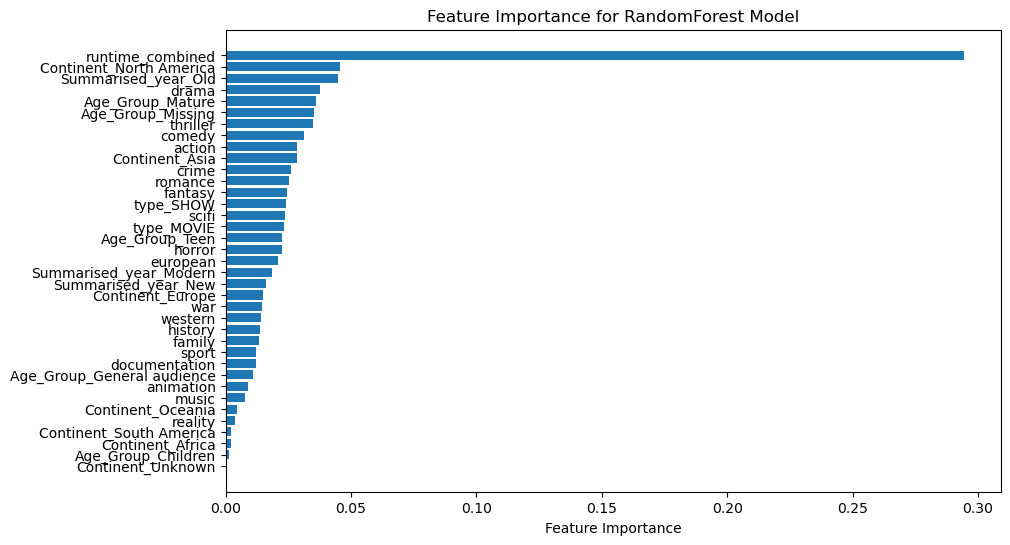

In [62]:
# Refresh plt
%matplotlib inline
plt.figure()

# Assuming you trained a RandomForestClassifier named 'rf_model'
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for RandomForest Model')
plt.gca().invert_yaxis()
plt.show()

## Backwards Feature Selection

In [73]:
# Propose to remove due to abnormally high influence
df_5 = df_4.drop(columns = ['runtime_combined'])

# Propose to remove due to possible influence of amount of time on the number of imdb votes accumulated over the years
df_6 = df_5.drop(columns = ['Summarised_year_Old','Summarised_year_Modern','Summarised_year_New'])

In [74]:
# Remove the target variable from training data
X = df_6.drop(columns = ['imdb_votes_binary','index'])

# Assign target variable to dataset
y = df_6['imdb_votes_binary']

In [76]:
df_6.head(50)

,index,type_MOVIE,type_SHOW,action,animation,comedy,crime,documentation,drama,european,...,Continent_North America,Continent_Oceania,Continent_South America,Continent_Unknown,Age_Group_Children,Age_Group_General audience,Age_Group_Mature,Age_Group_Missing,Age_Group_Teen,imdb_votes_binary
0,1,True,False,0,0,0,1,0,1,0,...,True,False,False,False,False,False,True,False,False,Good
1,2,True,False,0,0,1,0,0,0,0,...,False,False,False,False,False,True,False,False,False,Good
2,3,True,False,0,0,1,0,0,0,0,...,False,False,False,False,False,False,True,False,False,Good
3,4,True,False,0,0,0,0,0,0,0,...,True,False,False,False,False,False,True,False,False,Good
4,5,False,True,0,0,1,0,0,0,1,...,False,False,False,False,False,False,False,False,True,Bad
5,6,True,False,1,0,0,1,0,0,0,...,True,False,False,False,False,False,True,False,False,Good
6,7,True,False,0,0,0,0,0,1,0,...,True,False,False,False,False,True,False,False,False,Bad
7,8,True,False,0,0,0,0,0,1,0,...,True,False,False,False,False,False,True,False,False,Bad
8,9,True,False,1,0,0,1,0,1,0,...,True,False,False,False,False,False,True,False,False,Good
9,10,True,False,1,0,0,0,0,0,1,...,True,False,False,False,False,False,False,False,True,Bad


In [77]:
# Split it to a 70:30 Ratio Train:Test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

In [78]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier(n_estimators=10)))
models.append(('GB', GradientBoostingClassifier()))

In [79]:
print(len(y_train))
print(len(y_test))

3557
1525


In [80]:
results = []

for name, model in models:
    print(name)
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # Adjust average as needed
    recall = recall_score(y_test, y_pred, average='weighted')        # Adjust average as needed

    # Append the results to the list
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    })

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print('-' * 30)

# Convert the results list to a DataFrame for a tabular display
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

KNN
Accuracy: 0.9350819672131148
Precision: 0.9133433451884564
Recall: 0.9350819672131148
------------------------------
SVM


C:\Users\JianWei\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9429508196721311
Precision: 0.8891562483203439
Recall: 0.9429508196721311
------------------------------
LR
Accuracy: 0.939672131147541
Precision: 0.906192732706365
Recall: 0.939672131147541
------------------------------
DT
Accuracy: 0.9278688524590164
Precision: 0.915001892545721
Recall: 0.9278688524590164
------------------------------
GNB
Accuracy: 0.5521311475409836
Precision: 0.9429430487179054
Recall: 0.5521311475409836
------------------------------
RF
Accuracy: 0.9337704918032786
Precision: 0.9145030082243198
Recall: 0.9337704918032786
------------------------------
GB
Accuracy: 0.939672131147541
Precision: 0.9107606123113668
Recall: 0.939672131147541
------------------------------
  Model  Accuracy  Precision    Recall
0   KNN  0.935082   0.913343  0.935082
1   SVM  0.942951   0.889156  0.942951
2    LR  0.939672   0.906193  0.939672
3    DT  0.927869   0.915002  0.927869
4   GNB  0.552131   0.942943  0.552131
5    RF  0.933770   0.914503  0.933770
6    GB  0.9396

<Figure size 640x480 with 0 Axes>

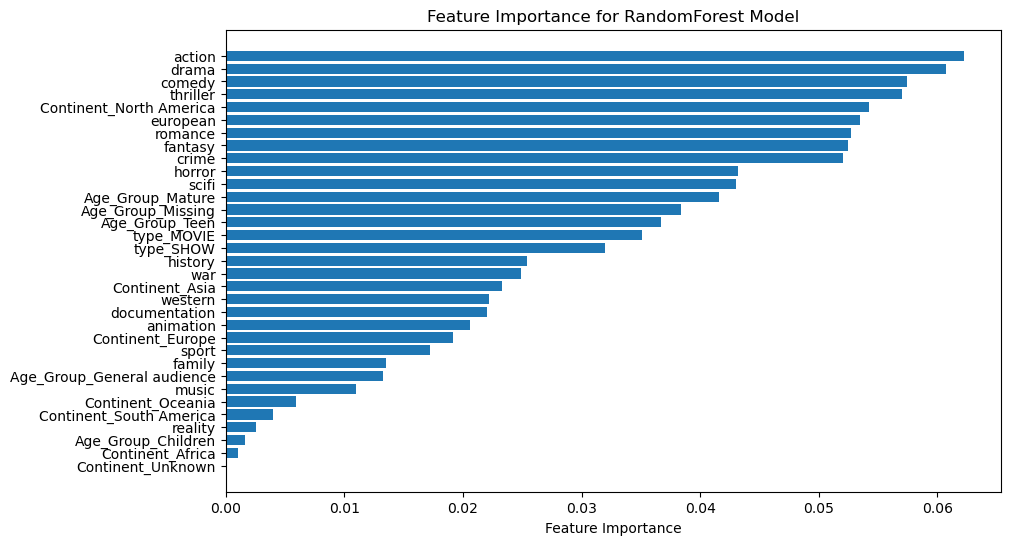

In [81]:
# Refresh plt
%matplotlib inline
plt.figure()

# Assuming you trained a RandomForestClassifier named 'rf_model'
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for RandomForest Model')
plt.gca().invert_yaxis()
plt.show()